In [2]:
import pandas as pd
import numpy as np
import data_bowl_functions as dbf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline


In [3]:
input_data, output_data, play_info = dbf.get_all_data()

In [4]:
input_data, output_data, play_info = dbf.get_target_plays(input_data, output_data, play_info)

In [5]:
play_info = dbf.add_to_play_info(input_data, output_data, play_info)


In [6]:
max_frame = pd.read_csv("max_frame.csv")

In [ ]:
#all_situations, all_probabilities, all_ball_positions = dbf.get_all_situation_data(play_info, input_data, output_data, max_frame)

In [7]:
all_situations = pd.read_csv('all_situations.csv')
all_probabilities = pd.read_csv('all_probabilities.csv')
all_ball_positions = pd.read_csv('all_ball_positions.csv')

In [8]:
play_info = play_info.merge(all_probabilities[all_probabilities['frame_id']==0].drop(columns=['frame_id']), on=['game_id', 'play_id'], how='left')
play_info = dbf.add_player_dir(all_situations, play_info)
play_info = dbf.add_ball_dir(all_situations, play_info)
play_info = dbf.add_starting_separation(play_info, all_situations)
play_info['def_move_path'] = np.vectorize(dbf.classify_movement_path)(play_info['play_direction'], play_info['def_ball_dir'], play_info['def_movement_dir'], 5)
play_info['outcome'] = np.select([play_info['pass_result']=='C', play_info['pass_result']=='I', play_info['pass_result']=='IN'], [0, 1, 1], default=0)

In [9]:
play_info['outcome'] = np.select([play_info['pass_result']=='C', play_info['pass_result']=='I', play_info['pass_result']=='IN'], [1, 0, 0], default=0)

In [10]:
play_info['total_bal_prob'] = play_info['off_bal_prob'] + play_info['def_bal_prob']

In [11]:
temp = play_info[play_info['total_bal_prob']>.90]

In [12]:
play_info['projected_outcome'] = np.select([0.5 < play_info['def_bal_prob']], [1], default=0)

In [13]:
play_info = dbf.add_starting_separation(play_info, all_situations)

In [14]:
qbs = input_data[(input_data['player_position']=='QB')].groupby(['game_id', 'play_id'])['player_name'].first().reset_index()
qb_first_frame = all_probabilities[all_probabilities['frame_id']==0].merge(qbs, on=['game_id', 'play_id'], how='left')
vis_list = qb_first_frame.groupby('player_name').size().sort_values(ascending=False).head(10).index.to_list()

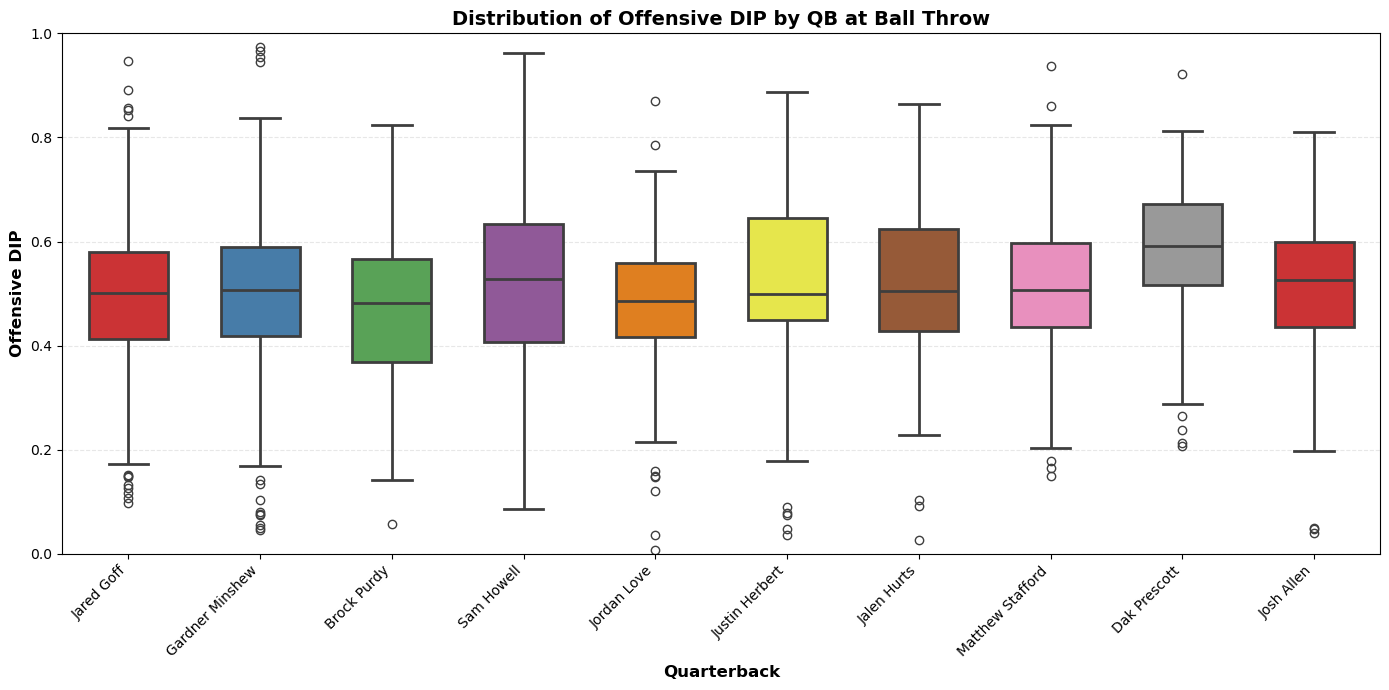

In [16]:
# Create box and whisker chart of offensive ball probability by QB
plt.figure(figsize=(14, 7))

# Filter data for QBs in vis_list
qb_data = qb_first_frame[qb_first_frame['player_name'].isin(vis_list)]

# Create the plot
sns.boxplot(
    data=qb_data,
    x='player_name',
    y='off_bal_prob',
    palette='Set1',
    width=0.6,
    linewidth=2,
    fliersize=6
)


# Labels and formatting
plt.xlabel('Quarterback', fontsize=12, fontweight='bold')
plt.ylabel('Offensive DIP', fontsize=12, fontweight='bold')
plt.title('Distribution of Offensive DIP by QB at Ball Throw', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

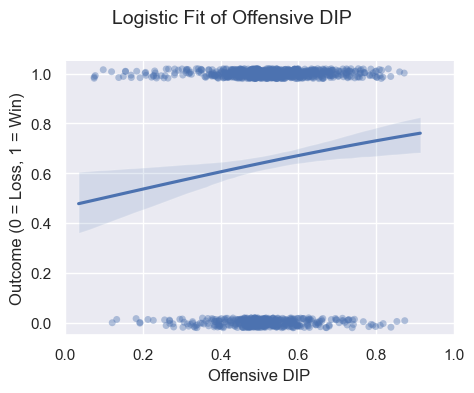

In [ ]:
sns.set_theme(style="darkgrid")

g = sns.lmplot(
    x="off_bal_prob",
    y="outcome",
    #col="def_move_path",
    #hue="def_move_path",
    data=temp[temp["def_move_path"] != "OUT"],
    y_jitter=0.02,
    logistic=True,
    truncate=False,
    height=4,
    aspect=1.2,
    scatter_kws={"alpha": 0.4, "s": 25, "edgecolor": "none"}
)

# Improve labels and titles
g.set_axis_labels("Offensive DIP", "Outcome (0 = Loss, 1 = Win)")
g.set_titles(col_template="Defender Movement: {col_name}")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Logistic Fit of Offensive DIP", fontsize=14)

# Axis limits
g.set(xlim=(0, 1), ylim=(-0.05, 1.05))

In [ ]:
# Create histograms using seaborn
plt.figure(figsize=(12, 6))

sns.histplot(
    data=temp,
    x='def_bal_prob',
    hue='pass_result',
    bins=10,
    alpha=0.7,
    edgecolor='black',
    palette='Set2'
)

# Labels and formatting
plt.xlabel('Offensive Ball Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Offensive Win Probability by Pass Result (Total Probability > 0.90)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()